In [1]:
# Mount drive
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/NLP/project/code'
%ls -l
print(os.listdir())

/content
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NLP/project/code
total 2188
-rw------- 1 root root  78787 May  9 14:15 Benchmark_embeddings.ipynb
-rw------- 1 root root   3534 Apr 22 16:32 cleaning.py
-rw------- 1 root root   4152 May  9 14:26 compute_embeddings.py
-rw------- 1 root root  14856 May  9 14:45 compute_from_embeddings.ipynb
-rw------- 1 root root 363996 May  9 10:48 master.zip
-rw------- 1 root root 363996 May  9 10:49 master.zip.1
-rw------- 1 root root 363996 May  9 10:51 master.zip.2
drwx------ 2 root root   4096 May  9 14:17 __pycache__/
-rw------- 1 root root  21800 Apr 25 09:06 pytorch_tuto.ipynb
drwx------ 2 root root   4096 May  1 16:25 sent2vec-master/
-rw------- 1 root root   2689 May  9 09:38 transform_dataset.py
-rw------- 1 root root 808814 May  4 08:33 Untitled0.ipynb
-rw------- 1 root root  22808 Apr 22 16:46 Untitled.ipynb
-rw------- 1 root root   3545 Apr 22 16:32 utils_cleaning.py
-rw------- 1 root root  21429 May  7 07:34 Vince

In [0]:
! pip install fuzzywuzzy
! pip install python-Levenshtein

In [2]:
import pandas as pd
import numpy as np
import random
import re
import time
from string import punctuation
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sns

import transform_dataset
import compute_embeddings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
questions1, questions2, is_duplicates = transform_dataset.clean_quora()
cleaned_questions1, cleaned_questions2, cleaned_is_duplicates = transform_dataset.clean_quora(output='tokenized_list')

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb

def get_features(embs1, embs2):
  return np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)

def model_efficiency(embs, labels):
  params = {}
  params['objective'] = 'binary:logistic'
  params['eval_metric'] = 'logloss'
  params['eta'] = 0.02
  params['max_depth'] = 4

  X_train, X_valid, y_train, y_valid = train_test_split(embs, labels, train_size = 0.7, random_state=42, shuffle=True, stratify=labels)
  target_train = y_train
  target_valid = y_valid

  d_train = xgb.DMatrix(X_train, label=target_train)
  d_valid = xgb.DMatrix(X_valid, label=target_valid)

  model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

  target_train = y_train
  target_valid = y_valid
  
  model.fit(X_train, target_train)
  
  predictions_train = model.predict(X_train)
  predictions_valid = model.predict(X_valid)

  proba_predictions_train = model.predict_proba(X_train)
  proba_predictions_valid = model.predict_proba(X_valid)

  loss_train = log_loss(target_train, proba_predictions_train)
  loss_valid = log_loss(target_valid, proba_predictions_valid)

  accuracy_train = accuracy_score(target_train, predictions_train)
  accuracy_valid = accuracy_score(target_valid, predictions_valid)

  f1_train = f1_score(target_train, predictions_train)
  f1_valid = f1_score(target_valid, predictions_valid)

  return {'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)}

In [0]:
def calculate_features_from_embeddings(path, embedding1_file, embedding2_file):
    embs1 = np.load(os.path.join(path, embedding1_file))
    embs2 = np.load(os.path.join(path, embedding2_file))
    return calculate_cosine(embs1, embs2)

def calculate_cosine(embs1, embs2):
    return (embs1 * embs2).sum(axis=1)/(np.linalg.norm(embs1, axis=1) * np.linalg.norm(embs2, axis=1))

def jaccard_type_feature(count1, count2, eps=1e-12):
  features = (count1.multiply(count2 != 0) + count2.multiply(count1 != 0)).sum(axis=1)
  features = features / (count1.sum(axis=1) + count2.sum(axis=1) + eps)
  return features

# Collect features

In [6]:
features = {}
precomputed_embeddings = ['SBERT_embeddings{}.npy', 'doc2vec_embeddings{}.npy', 'sent2vec_embeddings{}.npy']
for filename in precomputed_embeddings:
  cosine = calculate_features_from_embeddings('../data/', filename.format(1), filename.format(2))
  features[filename.split('_')[0]] = cosine

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [8]:
model = compute_embeddings.SIF()
# model = SIF()
model.load_model()
model.fit(cleaned_questions1+cleaned_questions2)
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)
cosine = calculate_cosine(embs1, embs2)
features['SIF'] = cosine

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [9]:
model = compute_embeddings.Count()
# model = Count()
model.load_model()
model.fit(questions1 + questions2)
count_embs1 = model.calculate_embeddings(questions1)
count_embs2 = model.calculate_embeddings(questions2)
count_features = jaccard_type_feature(count_embs1, count_embs2)
features['Count'] = np.array(count_features)[:,0]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [10]:
model = compute_embeddings.TFIDF()
# model = TFIDF()
model.load_model()
model.fit(questions1 + questions2)
tfidf_embs1 = model.calculate_embeddings(questions1)
tfidf_embs2 = model.calculate_embeddings(questions2)
tfidf_features = jaccard_type_feature(tfidf_embs1, tfidf_embs2)
features['TFIDF'] = np.array(tfidf_features)[:,0]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [0]:
df_train = pd.read_csv("../data/train.csv")
df_train = df_train.drop(['id', 'qid1', 'qid2'], axis=1)
df_train["question1"] = df_train["question1"].astype("str")
df_train["question2"] = df_train["question2"].astype('str')

In [0]:
# length based features
df_train['len_q1'] = df_train.question1.apply(lambda x: len(str(x)))
df_train['len_q2'] = df_train.question2.apply(lambda x: len(str(x)))
# difference in lengths of two questions
df_train['diff_len'] = df_train.len_q1 - df_train.len_q2

# character length based features
df_train['len_char_q1'] = df_train.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df_train['len_char_q2'] = df_train.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))

# word length based features
df_train['len_word_q1'] = df_train.question1.apply(lambda x: len(str(x).split()))
df_train['len_word_q2'] = df_train.question2.apply(lambda x: len(str(x).split()))

# common words in the two questions
df_train['common_words'] = df_train.apply(lambda x: len(set(str(x['question1'])
    .lower().split())
    .intersection(set(str(x['question2'])
    .lower().split()))), axis=1)

basics = ['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2', 'common_words']

In [0]:
import fuzzywuzzy
from fuzzywuzzy import fuzz

df_train['fuzz_qratio'] = df_train.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_WRatio'] = df_train.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_partial_ratio'] = df_train.apply(lambda x: fuzz.partial_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_partial_token_set_ratio'] = df_train.apply(lambda x: fuzz.partial_token_set_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_partial_token_sort_ratio'] = df_train.apply(lambda x: fuzz.partial_token_sort_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_token_set_ratio'] = df_train.apply(lambda x: fuzz.token_set_ratio(
str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_token_sort_ratio'] = df_train.apply(lambda x: fuzz.token_sort_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

fuzzys = ['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
          'fuzz_partial_token_sort_ratio','fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

In [0]:
feature_names = list(features.keys())
print([features[name].shape for name in feature_names])
all_features = np.concatenate([features[name][:,None] for name in feature_names], axis=1)
labels = np.array(is_duplicates)

In [0]:
all_features = np.concatenate((all_features, df_train[basics+fuzzys].values), axis=1)

In [0]:
np.save('../data/features.npy', all_features)

# Analyze features

In [70]:
all_features_df = pd.DataFrame(data = all_features, columns=feature_names+basics+fuzzys)
all_features_df.head()

,SBERT,doc2vec,sent2vec,SIF,Count,TFIDF,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0.840102,0.945714,0.909948,0.942983,0.769231,0.802452,66.0,57.0,9.0,20.0,20.0,14.0,12.0,10.0,93.0,95.0,98.0,100.0,89.0,100.0,93.0
1,0.746924,0.671681,0.069640,0.764839,0.307692,0.419284,51.0,88.0,-37.0,21.0,29.0,8.0,13.0,4.0,66.0,86.0,73.0,100.0,75.0,86.0,63.0
2,0.891067,0.797049,0.439930,0.783453,0.363636,0.317999,73.0,59.0,14.0,25.0,24.0,14.0,10.0,4.0,54.0,63.0,53.0,100.0,71.0,66.0,66.0
3,0.281117,0.567116,0.091834,0.111824,0.000000,0.000000,50.0,65.0,-15.0,19.0,26.0,11.0,9.0,0.0,35.0,35.0,30.0,37.0,38.0,36.0,36.0
4,0.453246,0.655056,0.166427,0.604846,0.000000,0.000000,76.0,39.0,37.0,25.0,18.0,13.0,7.0,2.0,46.0,86.0,54.0,100.0,63.0,67.0,47.0


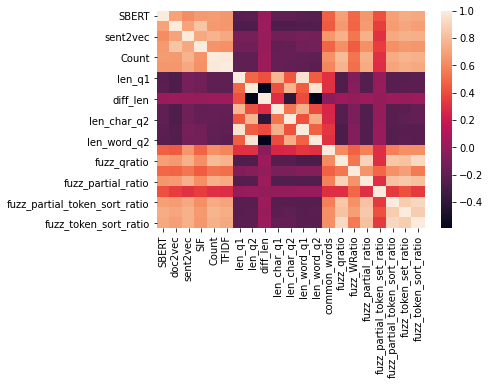

In [71]:
cor = all_features_df.corr()
sns.heatmap(cor)

In [72]:
print((np.array(is_duplicates)==1).sum())
print((np.array(is_duplicates)==0).sum())

149263
255027


# Learning

In [0]:
# rebalance dataset
from sklearn.utils import resample
all_features_labels = np.concatenate((all_features, labels[:,None]), axis=1)

tmp_duplicates = resample(all_features_labels[all_features_labels[:,-1]==1], replace=True, n_samples=(labels==0).sum(), random_state=42)
all_features_labels = np.concatenate((tmp_duplicates, all_features_labels[all_features_labels[:,-1]==0]))

new_all_features = all_features_labels[:,:-1]
new_labels = all_features_labels[:,-1]


In [74]:
print(len(all_features_labels[all_features_labels[:,-1]==1]))
print(len(all_features_labels[all_features_labels[:,-1]==0]))

255027
255027


In [75]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

X_train, X_valid, y_train, y_valid = train_test_split(new_all_features, new_labels, train_size = 0.7, random_state=42, shuffle=True, stratify=new_labels)
target_train = y_train
target_valid = y_valid

d_train = xgb.DMatrix(X_train, label=target_train)
d_valid = xgb.DMatrix(X_valid, label=target_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

# model.fit(X_train, target_train)

# predictions_train = model.predict(X_train)
# predictions_valid = model.predict(X_valid)

# proba_predictions_train = model.predict_proba(X_train)
# proba_predictions_valid = model.predict_proba(X_valid)

# loss_train = log_loss(target_train, proba_predictions_train)
# loss_valid = log_loss(target_valid, proba_predictions_valid)

# accuracy_train = accuracy_score(target_train, predictions_train)
# accuracy_valid = accuracy_score(target_valid, predictions_valid)

# f1_train = f1_score(target_train, predictions_train)
# f1_valid = f1_score(target_valid, predictions_valid)

[0]	train-logloss:0.685075	valid-logloss:0.685089
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.619105	valid-logloss:0.618451
[20]	train-logloss:0.569872	valid-logloss:0.571058
[30]	train-logloss:0.536083	valid-logloss:0.536664
[40]	train-logloss:0.510805	valid-logloss:0.511338
[50]	train-logloss:0.491136	valid-logloss:0.491878
[60]	train-logloss:0.475762	valid-logloss:0.477123
[70]	train-logloss:0.464724	valid-logloss:0.46582
[80]	train-logloss:0.455438	valid-logloss:0.456783
[90]	train-logloss:0.448103	valid-logloss:0.44963
[100]	train-logloss:0.442194	valid-logloss:0.443688
[110]	train-logloss:0.437511	valid-logloss:0.438871
[120]	train-logloss:0.433923	valid-logloss:0.435485
[130]	train-logloss:0.430849	valid-logloss:0.432606
[140]	train-logloss:0.428451	valid-logloss:0.430186
[150]	train-logloss:0.426323	valid-logloss:0.428001
[160]	train-logloss:0.424524	v